In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
data = pd.read_csv('data/train.csv', delimiter='|')
items = pd.read_csv('data/items.csv', delimiter='|')
test = pd.read_csv('data/class.csv', delimiter='|')
test_target = pd.read_csv('data/target.csv', delimiter='|')


d_len, d_ord_rate = dict(), dict()
for pid in items.pid.values:
    ords = data[data['pid'] == pid].order.values
    d_len[pid] = len(ords)
    d_ord_rate[pid] = np.mean(ords)

zero_len = [k for k, v in d_len.items() if v==0]
d_ord_rate = {k: v for k, v in d_ord_rate.items() if k not in zero_len}
zero_rate = [k for k, v in d_ord_rate.items() if v==0]
bad_pids = zero_len + zero_rate

data = data[~data.pid.isin(bad_pids)]
items = items[~items.pid.isin(bad_pids)]
test = test[~test.pid.isin(bad_pids)]


test_target['order'] = np.where(test_target.revenue.values>0, 1, 0)
test = pd.merge(test, test_target.drop('revenue', axis=1), how='inner', on='lineID')




fill_na = {
    'pharmForm': 'unknown',
    'category': -1,
    'campaignIndex': 'unknown'
}
for k, v in fill_na.items():
    items[k].fillna(v, inplace=True)


to_int = ['category']
for c in to_int:
    items[c] = items[c].astype('int')


to_lower = ['group', 'content', 'unit', 'pharmForm']
for c in to_lower:
    items[c] = items[c].map((lambda x: x.lower()))


label_encoder = ['group', 'content', 'unit', 'pharmForm', 'salesIndex', 'category', 'campaignIndex']
encoders = dict()
for c in label_encoder:
    enc = LabelEncoder()
    items[c] = enc.fit_transform(items[c].values)
    encoders[c] = enc


data = pd.merge(data, items, how='left', on='pid')
data.drop(['revenue', 'click', 'basket', 'lineID', 'day', 'pid'], axis=1, inplace=True)
test = pd.merge(test, items, how='left', on='pid')
test.drop(['lineID', 'day', 'pid'], axis=1, inplace=True)

/home/al/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/al/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
data.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)
#data.drop(data[np.abs(data.competitorPrice.values) == np.inf].index, inplace=True)
#test.drop(test[np.abs(test.competitorPrice.values) == np.inf].index, inplace=True)
data.reset_index()
test.reset_index()

"""
data['rrp'] = data.rrp.map(lambda x: np.log(1+x))
data['price'] = data.price.map(lambda x: np.log(1+x))
data['competitorPrice'] = data.competitorPrice.map(lambda x: np.log(1+x))

data['rrp2comp'] = data.rrp - data.competitorPrice
data['rrp2price'] = data.rrp - data.price
data['comp2price'] = data.competitorPrice - data.price

https://disk.yandex.ru/i/_bAJZhWqT7cG-Q
test['rrp'] = test.rrp.map(lambda x: np.log(1+x))
test['price'] = test.price.map(lambda x: np.log(1+x))
test['competitorPrice'] = test.competitorPrice.map(lambda x: np.log(1+x))

test['rrp2comp'] = test.rrp - test.competitorPrice
test['rrp2price'] = test.rrp - test.price
test['comp2price'] = test.competitorPrice - test.price
"""

#data['rrp'] = data.rrp.map(lambda x: np.log(1+x))
data['price'] = data.price / data.rrp
data['competitorPrice'] = data.competitorPrice / data.rrp

#data['rrp2comp'] = data.rrp - data.competitorPrice
#data['rrp2price'] = data.rrp - data.price
#data['comp2price'] = data.competitorPrice - data.price


#test['rrp'] = test.rrp.map(lambda x: np.log(1+x))
test['price'] = test.price / test.rrp
test['competitorPrice'] = test.competitorPrice / test.rrp

#test['rrp2comp'] = test.rrp - test.competitorPrice
#test['rrp2price'] = test.price / test.rrp
#test['comp2price'] = test.competitorPrice / test.rrp


#cols = ['rrp2comp', 'rrp2price', 'comp2price', 'rrp', 'price', 'competitorPrice']
#std_sc = StandardScaler()
#data.loc[:, cols] = std_sc.fit_transform(data.loc[:, cols])
#test.loc[:, cols] = std_sc.transform(test.loc[:, cols])

In [6]:
data.head()

,adFlag,availability,competitorPrice,order,price,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,0,2,0.800000,0,0.925479,255,515,374,5,141,0,0,193,3,18.25
1,1,1,0.455609,0,0.465178,18,362,374,7,129,1,0,66,2,18.81
2,0,1,0.799242,0,0.869048,41,490,236,5,124,0,3,40,3,18.48
3,1,1,0.707841,1,0.703545,52,299,408,1,42,0,0,25,3,9.31
4,0,1,0.539975,1,0.509225,90,445,192,7,70,0,3,14,3,8.13


In [7]:
a, b = list(), list()
i=0

for x in data.group.unique():
    if i%2==0:
        a.append(x)
    else:
        b.append(x)
    i+=1

In [15]:
X_test = data[data.group.isin(a)]
X_test = X_test.drop('rrp', axis=1)
X_test = X_test.drop('group', axis=1)
y_test = X_test.order
X_test = X_test.drop('order', axis=1)

X_train = data[data.group.isin(b)]
X_train = X_train.drop('rrp', axis=1)
X_train = X_train.drop('group', axis=1)
y_train = X_train.order
X_train = X_train.drop('order', axis=1)

In [16]:
data.shape, X_train.shape, X_test.shape

((2628676, 15), (1425839, 12), (1202837, 12))

In [17]:
X_train.shape[0] + X_test.shape[0]

2628676

In [18]:
#X_train, X_test = X_test, X_train
#y_train, y_test = y_test, y_train

In [19]:
#y = data.order
#X = data.drop('order', axis=1)
#X = X.drop('rrp', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1337)
X_test, X_test_val, y_test, y_test_val = train_test_split(X_test, y_test, test_size=0.2, random_state=1337)
#X_test, y_test = test.drop('order', axis=1), test.order
#X_test = X_test.drop('rrp', axis=1)

In [20]:
X_train.head()

,adFlag,availability,competitorPrice,price,manufacturer,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex
367249,0,3,0.791317,1.000000,84,408,7,41,0,0,208,3
1304904,1,1,0.545370,0.717961,52,105,1,42,0,0,25,3
2508942,1,1,0.657030,0.719448,65,189,5,78,0,0,121,3
387161,0,1,0.714906,0.549928,18,249,5,101,0,0,72,3
1204692,1,1,0.502079,0.452183,18,132,7,41,1,0,50,3


In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve


fit_params={"eval_metric" : 'auc', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto',
            'categorical_feature': [
                'adFlag',
                'availability',
                'manufacturer',
                #'group',
                'content',
                'unit',
                'pharmForm',
                'genericProduct',
                'salesIndex',
                'category',
                'campaignIndex'
            ]
           }

clf_train = LGBMClassifier(num_leaves=15, max_depth=-1, 
                     random_state=314,
                     metric='auc',
                     n_jobs=4,
                     n_estimators=1000,
                     colsample_bytree=0.9,
                     subsample=0.9,
                     learning_rate=0.1,
                     early_stopping_rounds=10,
                     verbose=200)

clf_train.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 306663, number of negative: 834008
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.797660
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.252844
[LightGBM] [Debug] init for col-wise cost 0.022776 seconds, init for row-wise cost 0.055871 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1577

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Tra

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=10, metric='auc',
               n_estimators=1000, n_jobs=4, num_leaves=15, random_state=314,
               subsample=0.9, verbose=200)

In [23]:
preds = clf_train.predict_proba(X_val)
print(roc_auc_score(y_val, preds[:, 1]))

0.7049783593256586


In [24]:
preds = clf_train.predict_proba(X_test)
print(roc_auc_score(y_test, preds[:, 1]))

0.6006974135419357


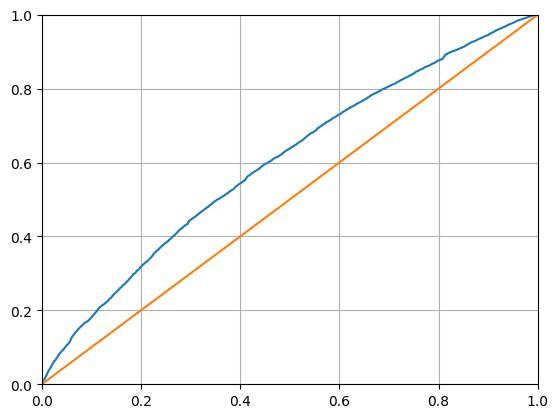

In [25]:
fpr, tpr, _ = roc_curve(y_test, preds[:, 1])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [26]:
fit_params={"eval_metric" : 'auc', 
            "eval_set" : [(X_test_val, y_test_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto',
            'categorical_feature': [
                'adFlag',
                'availability',
                'manufacturer',
                #'group',
                'content',
                'unit',
                'pharmForm',
                'genericProduct',
                'salesIndex',
                'category',
                'campaignIndex'
            ]
           }

clf_test = LGBMClassifier(num_leaves=15, max_depth=-1, 
                     random_state=314,
                     metric='auc',
                     n_jobs=4,
                     n_estimators=1000,
                     colsample_bytree=0.9,
                     subsample=0.9,
                     learning_rate=0.1,
                     early_stopping_rounds=10,
                     verbose=200)

clf_test.fit(X_test, y_test, **fit_params)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 244591, number of negative: 717678
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.814725
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.269876
[LightGBM] [Debug] init for col-wise cost 0.017147 seconds, init for row-wise cost 0.041521 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1570

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Train

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=10, metric='auc',
               n_estimators=1000, n_jobs=4, num_leaves=15, random_state=314,
               subsample=0.9, verbose=200)

In [29]:
preds = clf_test.predict_proba(X_test_val)
print(roc_auc_score(y_test_val, preds[:, 1]))

0.701694679335944


In [30]:
preds = clf_test.predict_proba(X_train)
print(roc_auc_score(y_train, preds[:, 1]))

0.5822278148609272


In [119]:
def elastisity_curve(x, p_arr):
    probs = list()
    for p in p_arr:
        x.price = p
        #x.rrp2price = x.rrp - x.price
        #x.comp2price = x.competitorPrice - x.price
        probs.append(clf_train.predict_proba(x.values.reshape(1,-1))[0, 1])
    return probs

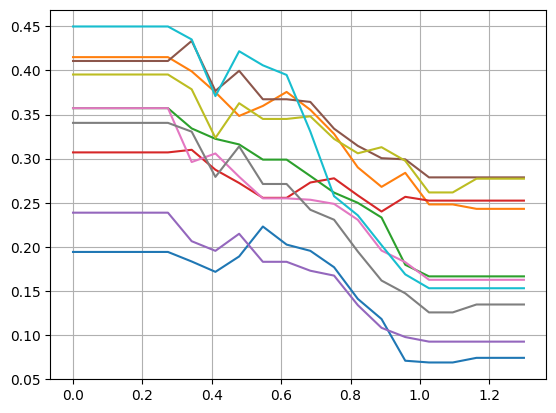

In [120]:
n=10
for i in np.random.choice(100000, n, replace=False):
    x = X_test.iloc[i]
    p_arr = np.linspace(0., 1.3, 20)
    buy_probs = np.array(elastisity_curve(x, p_arr))#* p_arr * x.rrp
    plt.plot(p_arr, buy_probs)
#for i in np.random.choice(100000, n, replace=False):
#    x = X_train.iloc[i]
#    p_arr = np.linspace(0., 1.3, 20)
#    buy_probs = np.array(elastisity_curve(x, p_arr))#* p_arr * x.rrp
#    plt.plot(p_arr, buy_probs, c='g')
plt.grid()
plt.show()

In [122]:
maximum_rewenue_price = list()
n = 1000
a,b,c = 0.5, 0.9, 100
for i in tqdm(np.random.choice(100000, n, replace=False), total=n):
    x = X_train.iloc[i]
    p_arr = np.linspace(a, b, c)
    returns = np.array(elastisity_curve(x, p_arr)) * p_arr
    maximum_rewenue_price.append(p_arr[np.argmax(returns)])

100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.97it/s]


[]

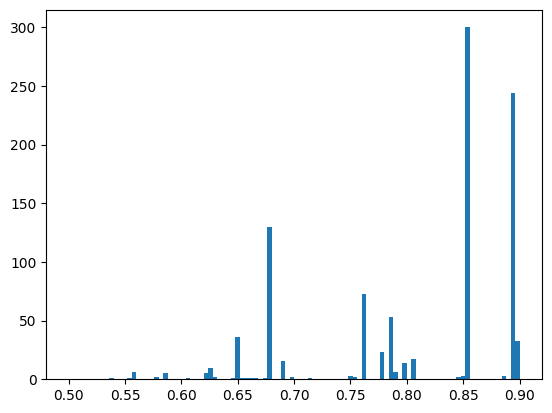

In [76]:
plt.hist(maximum_rewenue_price, bins=c, range=(a, b))
plt.plot()

In [158]:
X_train.iloc[0]

adFlag               1.000000
availability         1.000000
competitorPrice      0.088097
price                0.103519
manufacturer        37.000000
content              7.000000
unit                 5.000000
pharmForm           78.000000
genericProduct       0.000000
salesIndex           0.000000
category           101.000000
campaignIndex        3.000000
Name: 2095686, dtype: float64

In [151]:
q = np.arange(100)

In [156]:
q = np.random.permutation(q)

In [157]:
q

array([ 4, 23, 25, 45, 54, 39, 72, 81, 27, 43, 33, 80, 69, 59, 85, 68, 79,
       40, 13, 44, 12, 29, 87,  0, 50, 15, 70, 10, 95, 31, 90, 34,  5, 76,
       41, 64, 66,  6, 46, 37, 98, 18,  8, 56, 67, 53, 93, 24, 84, 73, 26,
        9, 75, 61, 16, 47, 22, 96, 97, 55,  7, 83, 17, 51, 89, 62, 57, 94,
       78,  2, 14, 49, 30, 32, 63, 60, 20, 65, 77, 11, 48, 21,  3, 88, 99,
       82, 19, 42, 52, 71,  1, 28, 91, 58, 38, 36, 86, 92, 74, 35])

In [84]:
import warnings
warnings.simplefilter(action='ignore')

In [106]:
class PharmEnv():
    def __init__(self, data, model_unknown, lower_bound=0.3, upper_bound=0.9, n=20):
        self.data = data
        self.inds = np.arange(data.shape[0])
        self.data_len = data.shape[0]
        self.i = 0
        self.obs = None
        
        self.model_unknown = model_unknown
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.n = n
    
    def obserwation(self):
        self.obs = self.data.iloc[self.inds[self.i]]
        self.i += 1
        return self.obs
    
    def reset(self):
        self.inds = np.random.permutation(self.inds)
        return self.obserwation()
    
    def step(self, action):
        
        x = self.obs
        x.price = action
        p = self.model_unknown.predict_proba(x.values.reshape(1,-1))[0, 1]
        
        reward = action if np.random.rand() < p else 0
        exp_reward = p * action
        best_exp_reward, best_action = self.get_optimal_reward()
        
        if self.i == self.data_len:
            obs = self.reset()
            done = True
        else:
            obs = self.obserwation()
            done = False
        
        info = {
            "expected_reward": exp_reward,
            "best_expected_reward": best_exp_reward,
            "best_action": best_action
        }
        return obs, reward, done, info
    
    def get_optimal_reward(self):
        p_arr = np.linspace(self.lower_bound, self.upper_bound, self.n)
        probs = list()
        x = self.obs
        for p in p_arr:
            x.price = p
            probs.append(self.model_unknown.predict_proba(x.values.reshape(1,-1))[0, 1])
        exp_returns = np.asarray(probs) * p_arr
        return np.max(exp_returns), p_arr[np.argmax(exp_returns)]


In [107]:
test_env = PharmEnv(X_train, clf_test)

In [108]:
obs = test_env.reset()

In [109]:
obs, reward, done, info = test_env.step(0.6)

In [110]:
reward

0.6

In [111]:
info

{'expected_reward': 0.1665446923779405,
 'best_expected_reward': 0.1924521956929712,
 'best_action': 0.7421052631578948}

In [112]:
def get_optimal_price(model, x, lower_bound=0.3, upper_bound=0.9, n=20):
    p_arr = np.linspace(lower_bound, upper_bound, n)
    probs = list()
    for p in p_arr:
        x.price = p
        probs.append(model.predict_proba(x.values.reshape(1,-1))[0, 1])
    exp_returns = np.asarray(probs) * p_arr
    best_ind = np.argmax(exp_returns)
    return p_arr[best_ind]

In [113]:
best_p = get_optimal_price(clf_train, obs)
print(best_p)

0.836842105263158


In [114]:
obs, reward, done, info = test_env.step(best_p)
print(info)

{'expected_reward': 0.15362554758973154, 'best_expected_reward': 0.17840416398963835, 'best_action': 0.6473684210526316}


In [125]:
obs = test_env.reset()
total_expected_reward, total_best_expected_reward = [0], [0]
for i in tqdm(range(10000)):
    best_p = get_optimal_price(clf_train, obs)
    obs, reward, done, info = test_env.step(best_p)
    total_expected_reward.append(info['expected_reward']+total_expected_reward[-1])
    total_best_expected_reward.append(info['best_expected_reward']+total_best_expected_reward[-1])

100%|█████████████████████████████████████| 10000/10000 [01:44<00:00, 95.43it/s]


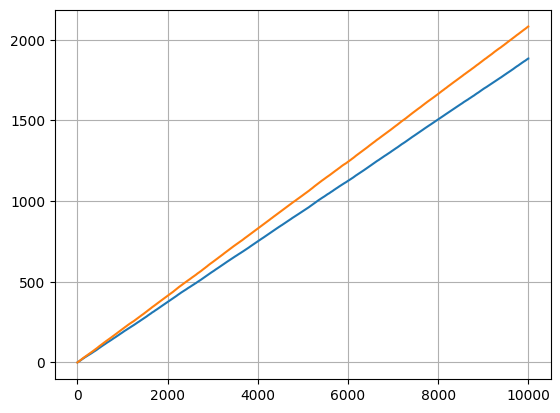

In [128]:
x = np.arange(10001)
plt.plot(x, total_expected_reward)
plt.plot(x, total_best_expected_reward)
plt.grid()
plt.show()

In [130]:
(total_best_expected_reward[-1] - total_expected_reward[-1]) / total_best_expected_reward[-1]

0.09533311678496034